In [1]:
%matplotlib inline

import os
import sys
import struct
from time import time

sys.path.append("/home/matthew/lscsoft/.virtualenvs/lalapps_knope_O2/lib/python2.7/site-packages")

import numpy as np
from matplotlib import pyplot as pl

import lalpulsar

In [22]:
%load_ext Cython

In [72]:
%%cython --compile-args=-O2

import numpy as np
cimport numpy as np

from libc.math cimport sqrt, cos, sin

from lalpulsar import ComputeEccentricAnomaly

# function to return binary BT model
def binary_model(w0, T0, Pb, asini, ecc, ts):
    # calculate the binary time delay for a Keplerian orbit
    
    orbits = (ts - T0)/Pb
    
    phase = 2.*np.pi*np.fmod(orbits, 1.)
    
    #u = eccentric_anomaly(phase, ecc)
    l = len(phase)
    u = np.zeros(l)
    for i in xrange(l):
        u[i] = ComputeEccentricAnomaly(phase[i], ecc)

    su = np.sin(u)
    cu = np.cos(u)
    
    sw = np.sin(w0)
    cw = np.cos(w0)
    
    x = asini
    e = ecc
    
    one_e2 = sqrt(1. - e**2)
    
    deltaTW1 = x*sw*(cu - e) + x*cw*one_e2*su
    deltaTW2 = (2.*np.pi/Pb)*(x*cw*one_e2*cu - x*sw*su)/(1.0 - e*cu)
    
    dt = -(deltaTW1*(1. - deltaTW2))
    
    return dt, deltaTW1, deltaTW2    

In [5]:
# show test of residuals
rundir1 = '/home/matthew/repositories/greedycpp/scripts/barycenter/binary/term1'

# get time stamps
ts = np.loadtxt(os.path.join(rundir1, 'quad_rule.txt'))
t = ts[:,0]

lenb = len(t)

# get number of basis
Nb1 = np.loadtxt(os.path.join(rundir1, 'ApproxErrors.txt')).shape[0]

# read in binary version of reduced basis data
bf = open(os.path.join(rundir1,'Basis.bin'), 'rb')
fc = bf.read()
bf.close()

rb1 = np.zeros((Nb1,lenb))
for i in range(Nb1):
    tmpvals = struct.unpack('d'*lenb*2, fc[(i*8*lenb*2):(i+1)*8*lenb*2])
    rb1[i] = tmpvals[::2] # just get real part
    
# read in binary version of empirical interpolation matrix
invV1 = np.zeros((Nb1, Nb1))
bf = open(os.path.join(rundir1,'invV.bin'), 'rb')
fc = bf.read()
bf.close()
for i in range(Nb1):
    tmpvals = struct.unpack('d'*Nb1*2, fc[(i*8*Nb1*2):(i+1)*8*Nb1*2])
    invV1[i] = tmpvals[::2] # just get real part
    
# show test of residuals
rundir2 = '/home/matthew/repositories/greedycpp/scripts/barycenter/binary/term2'

# get number of basis
Nb2 = np.loadtxt(os.path.join(rundir2, 'ApproxErrors.txt')).shape[0]

# read in binary version of reduced basis data
bf = open(os.path.join(rundir2,'Basis.bin'), 'rb')
fc = bf.read()
bf.close()

rb2 = np.zeros((Nb2,lenb))
for i in range(Nb2):
    tmpvals = struct.unpack('d'*lenb*2, fc[(i*8*lenb*2):(i+1)*8*lenb*2])
    rb2[i] = tmpvals[::2] # just get real part
    
# read in binary version of empirical interpolation matrix
invV2 = np.zeros((Nb2, Nb2))
bf = open(os.path.join(rundir2,'invV.bin'), 'rb')
fc = bf.read()
bf.close()
for i in range(Nb2):
    tmpvals = struct.unpack('d'*Nb2*2, fc[(i*8*Nb2*2):(i+1)*8*Nb2*2])
    invV2[i] = tmpvals[::2] # just get real part

In [92]:
# get random phases, start times and eccentricities and check residuals
nbins = 1000

# fixed parameters
Pb = 86400.
asini = 1.

eccmax = 0.1 # maximum eccentricity of the basis set
ecc = eccmax*np.random.rand(nbins)
w0 = 2.*np.pi*np.random.rand(nbins)
T0 = np.random.rand(nbins)

deltaTs = np.zeros(lenb)
deltaTsArray = []

par = lalpulsar.PulsarParameters()

binarytype = "BT"
lalpulsar.PulsarAddREAL8Param( par, "PB", Pb )
lalpulsar.PulsarAddREAL8Param( par, "A1", asini )
lalpulsar.PulsarAddStringParam( par, "BINARY", binarytype )

# get deltaTs calculated over all times using LALBarycenter routines
for i in range(nbins):
    bininput = lalpulsar.BinaryPulsarInput()
    binoutput = lalpulsar.BinaryPulsarOutput()
    
    lalpulsar.PulsarAddREAL8Param( par, "ECC", ecc[i] )
    lalpulsar.PulsarAddREAL8Param( par, "OM", w0[i] )
    lalpulsar.PulsarAddREAL8Param( par, "T0", t[0]+T0[i]*Pb )

    # set GPS time
    for j, tv in enumerate(t):
        bininput.tb = tv
        
        # perform binary barycentring
        lalpulsar.BinaryPulsarDeltaTNew( binoutput, bininput, par )
        deltaTs[j] = binoutput.deltaT
    
    deltaTsArray.append(np.copy(deltaTs))

In [85]:
# perform some timing evalution
ts = np.zeros(len(t))
tsTW1 = np.zeros(len(t))
tsTW2 = np.zeros(len(t))

ta = time()
dt, deltaTW1, deltaTW2 = binary_model(w0[-1], t[0]+T0[-1]*Pb, Pb, asini, ecc[-1], t)
tb = time()

print("Total time for evalution = %.9f" % (tb-ta))
print("time for one evaluation = %.9f" % ((tb-ta)/len(t)))

Total time for evalution = 0.000701904
time for one evaluation = 0.000000501


In [100]:
# get deltaTs calculated using interpolant
deltaTsArrayTerm1 = []
dtvals = np.zeros(Nb1)

ts_nodes1 = np.loadtxt(os.path.join(rundir1, 'EIM_nodes.txt'))

B1 = np.einsum('ik,ij->kj', invV1, rb1)

# get deltats calculated using the reduced basis
for i in range(nbins):
    # get values of deltaT at given points
    _, dtvals, _ = binary_model(w0[i], t[0]+T0[i]*Pb, Pb, asini, ecc[i], ts_nodes1)
        
    # create new version of deltaTs using empirical interpolant matrix
    deltaTsArrayTerm1.append(np.einsum('i,ij->j', dtvals, B1))

# time linear algebra
%timeit np.einsum('i,ij->j', dtvals, B1)
%timeit np.dot(dtvals, B1)

# get deltaTs calculated using interpolant
deltaTsArrayTerm2 = []
dtvals = np.zeros(Nb2)

ts_nodes2 = np.loadtxt(os.path.join(rundir2, 'EIM_nodes.txt'))

B2 = np.einsum('ik,ij->kj', invV2, rb2)

# get deltats calculated using the reduced basis
for i in range(nbins):    
    # get values of deltaT at given points
    _, _, dtvals = binary_model(w0[i], t[0]+T0[i]*Pb, Pb, asini, ecc[i], ts_nodes2)

    # create new version of deltaTs using empirical interpolant matrix
    deltaTsArrayTerm2.append(np.einsum('i,ij->j', dtvals, B2))

# time linear algebra
%timeit np.einsum('i,ij->j', dtvals, B2)
%timeit np.dot(dtvals, B2)

deltaTsArrayFull = []
for i in range(nbins):
    deltaTsArrayFull.append(-deltaTsArrayTerm1[i]*(1.-deltaTsArrayTerm2[i]))
    
%timeit lambda x:-deltaTsArrayTerm1[0]*(1.-deltaTsArrayTerm2[0])

100000 loops, best of 3: 11.7 µs per loop
The slowest run took 17.63 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 7.21 µs per loop
100000 loops, best of 3: 6.63 µs per loop
The slowest run took 9.29 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 6.26 µs per loop
10000000 loops, best of 3: 52.8 ns per loop


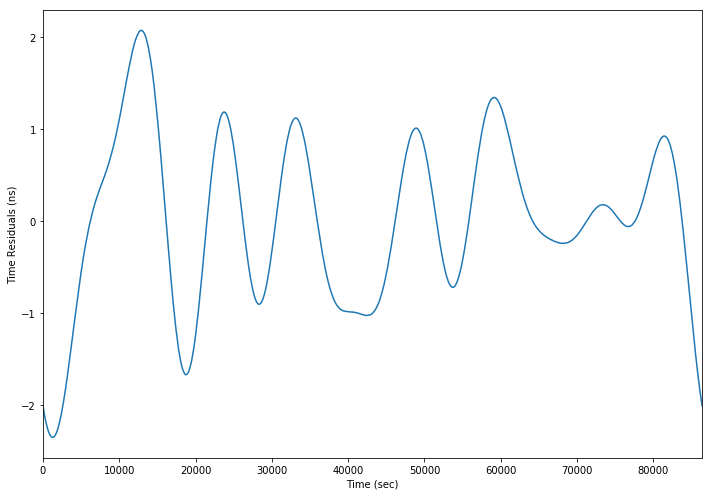

In [94]:
fig, ax1 = pl.subplots(figsize=(10,7))

ax1.plot(t-t[0], (deltaTsArrayFull[0]-deltaTsArray[0])*1e9)

ax1.set_ylabel('Time Residuals (ns)')
ax1.set_xlabel('Time (sec)')
ax1.set_xlim([0., (t[-1]-t[0])])

fig.tight_layout()

(array([ 231.,  399.,  209.,   71.,   31.,   24.,   10.,    4.,    7.,
           4.,    5.,    2.,    0.,    2.,    0.,    0.,    0.,    0.,
           0.,    1.]),
 array([  0.21973001,   1.18306329,   2.14639656,   3.10972983,
          4.07306311,   5.03639638,   5.99972966,   6.96306293,
          7.92639621,   8.88972948,   9.85306275,  10.81639603,
         11.7797293 ,  12.74306258,  13.70639585,  14.66972913,
         15.6330624 ,  16.59639567,  17.55972895,  18.52306222,  19.4863955 ]),
 <a list of 1 Patch objects>)

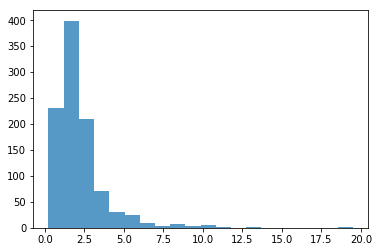

In [98]:
maxdt = []
for i in range(nbins):
    maxdt.append(np.max((deltaTsArrayFull[i]-deltaTsArray[i])*1e9))

pl.hist(maxdt, bins=20, histtype='stepfilled', alpha=0.75)

In [102]:
# compare times
full = 0.000701904*1e6 # time in microseconds

rom = 0.000000501*1e6*(Nb1 + Nb2) # time for computing time delay at nodes
rom += 11.7  # matrix multiplication (for first term)
rom += 7.2   # dot product for first term
rom += 6.6   # matrix multiplication (for second term)
rom += 6.3   # dot product for second term
rom += 53e-3 # combining terms for full time delay

In [103]:
print full, rom, (full/rom)

701.904 46.382 15.1331119831
